# Music Recommendation System

Music Recommendation Systems are a subset of Recommendation Systems that predict user preferences and recommend songs based on a variety of factors.

Music service providers use machine learning algorithms to process data from a million sources and present the listener with the most relevant songs when developing this recommendation system.

There are three kinds of recommendation systems: content-based, collaborative, and popularity-based. The content-based system predicts what a user will like based on previous preferences. The collaborative system predicts what a specific user will like based on what other similar users will like. The issue with a popularity-based recommendation system is that personalization is not possible; that is, even if the user's behavior is known, a personalized recommendation cannot be made.

### Importing the libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import sklearn.metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Reading the dataset

Our datasets are downloaded from WSDM - https://www.kaggle.com/c/kkbox-music-recommendation-challenge .

*Because the original training and test datasets are too large. Furthermore, the test data provided by Kaggle lacks labels. As a result, we discarded the test data and extracted 100000 samples from the training data, dividing them into 70000 (ntr) samples for training and 300000 (nts) samples for testing.*

In [3]:
ntr = 70000
nts = 30000

In [4]:
train = pd.read_csv('train.csv', nrows =ntr)
names=['msno','song_id','source_system_tab','source_screen_name',\
      'source_type','target']
test1 = pd.read_csv('train.csv',names = names, skiprows = ntr,nrows = nts)

In [5]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


### train.csv
- msno: user id
- song_id: song id
- source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
- source_screen_name: name of the layout a user sees.
- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
- target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

In [6]:
members = pd.read_csv('members.csv')

In [7]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


### members.csv
user information.

- msno
- city
- bd: age. Note: this column has outlier values, please use your judgement.
- gender
- registered_via: registration method
- registration_init_time: format %Y%m%d
- expiration_date: format %Y%m%d

In [8]:
songs = pd.read_csv('songs.csv')

In [9]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


### songs.csv
The songs. Note that data is in unicode.

- song_id
- song_length: in ms
- genre_ids: genre category. Some songs have multiple genres and they are separated by |
- artist_name
- composer
- lyricist
- language

### Data Preprocessing

Now we have songs.csv, members.csv and train.csv , we want to reduce them into two tables: test and train1. We could use left join operation to merge members and songs into train and test data, so that we have more feature columns to train. Besides, we need to remove the null data from the dataset.

To test the learned recommendation system in the end, we extract the true labels of test data into true_test

In [10]:
test = test1.drop(['target'], axis = 1)
true_test = np.array(test1['target'])


Rearranging columns of the test data

In [11]:

test_name = ['id','msno','song_id','source_system_tab','source_screen_name','source_type']
test['id']=np.arange(nts)
test = test[test_name]

Lambda Functions are anonymous function means that the function is without a name.

Since the members registration time is not semantic, we could split it into three fields: year, month and date. Same with expiration date and we dropped the original registration time column

In [12]:
members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
members['registration_month'] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
members['registration_date'] = members['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

In [13]:
members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0:4]))
members['expiration_month'] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
members['expiration_date'] = members['expiration_date'].apply(lambda x: int(str(x)[6:8]))
members = members.drop(['registration_init_time'], axis=1)

### Merging the datasets

In [14]:
members_cols = members.columns
train = train.merge(members[members_cols], on='msno', how='left')
test = test.merge(members[members_cols], on='msno', how='left')

### Visualizing the datasets

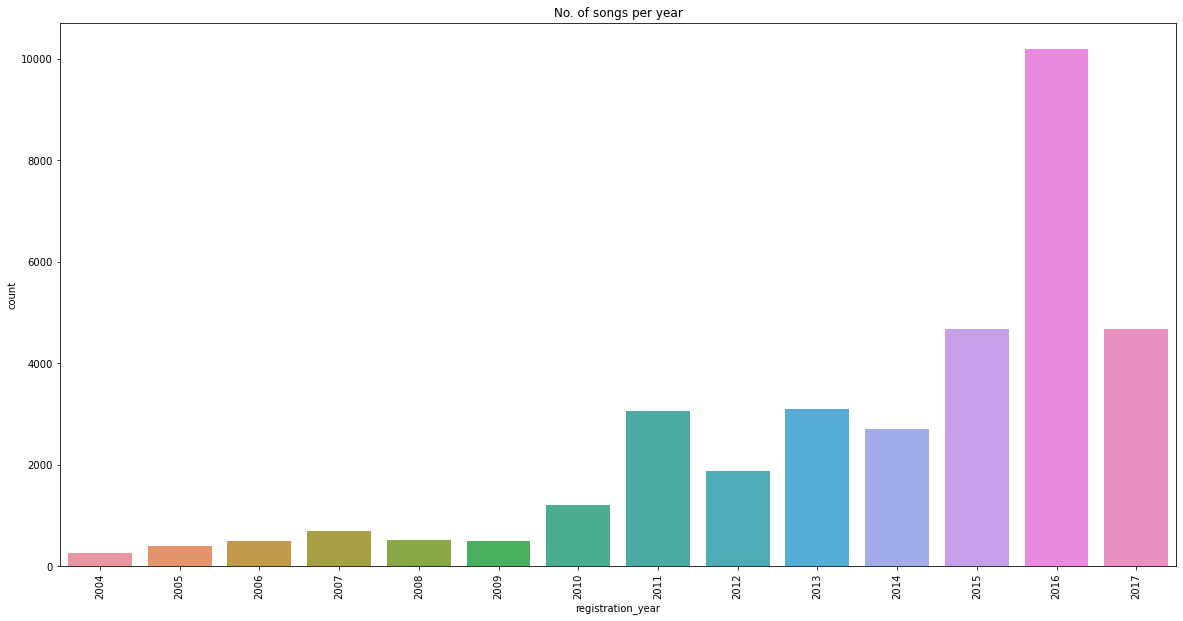

In [15]:
plt.figure(figsize=(20,10))
#mdf=sns.load_dataset('members')
sns.countplot(x='registration_year',data=members)
plt.xticks(rotation=90)
plt.title("No. of songs per year")
plt.show()

### Building the recommendation system

In [16]:
class Recommendation():
    def __init__(self, data, msno, song_id):
        self.data = data
        self.msno = msno
        self.song_id = song_id
        self.glcm = None
        
    def song_history(self, user):
        user_data = self.data[self.data[self.msno] == user]
        return list(user_data[self.song_id].unique())
        
    def users(self, item):
        item_data = self.data[self.data[self.song_id] == item]
        return set(item_data[self.msno].unique())
    
    def all_songs(self):
        return list(self.data[self.song_id].unique())
        
    def get_glcm(self, user_songs, all_songs):
        users = []        
        for p in range(0, len(user_songs)):
            users.append(self.users(user_songs[p]))   
        glcm = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)

        for p in range(0,len(all_songs)):
            songs_p_data = self.data[self.data[self.song_id] == all_songs[p]]
            users_p = set(songs_p_data[self.msno].unique())
            
            for q in range(0,len(user_songs)):           
                users_q = users[q]
                users_intersection = users_p.intersection(users_q)
               
                users_union = users_p.union(users_q)
                glcm[q,p] = float(len(users_intersection))/float(len(users_union))

        return glcm
    
    def generate(self, user, glcm, all_songs, user_songs):
        scores = glcm.sum(axis=0)/float(glcm.shape[0])
        scores = np.array(scores)[0].tolist()
        sort_index = sorted(((e,p) for p,e in enumerate(list(scores))), reverse=True)
        columns = ['msno', 'song_id', 'Score', 'Rank']
        test = pd.DataFrame(columns=columns)
         
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                test.loc[len(test)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        print("Music Recommendations: \n")
        return test.drop(['msno'], axis=1)

    def get_recommendations(self, user):
        user_songs = self.song_history(user)    
        all_songs = self.all_songs()
        glcm = self.get_glcm(user_songs, all_songs)
        return self.generate(user, glcm, all_songs, user_songs)

    def get_similar_songs(self, item_list):
        user_songs = item_list
        all_songs = self.all_songs()
        glcm = self.get_glcm(user_songs, all_songs)
        return self.generate("", glcm, all_songs, user_songs)
   

### Get Song history for a user

In [17]:
r = Recommendation(test,'msno','song_id')
history=r.song_history(test['msno'][6])

In [18]:
print("Song history of the user:\n")
for song in history:
  print(song)

Song history of the user:

R2l504ETlUbaICuQds72fwF7KNiQHpxPIvKuTDEOe00=
/EEIY5zmktFRYc4rPuvAmfCz0lT+NO7pDqozOxCzTgk=
e4Ab5yXqyiJWEZEubEsMRg3SzlcYxYAnYtp2Vk0EFlo=
ZspPLVW5PYTF+mrM84EiF3n6o+fwnbyjioO0EiYm5no=
31TBJaVwLi5tzfBwPCfyIH+YIXntxl373NiA++iZf+0=
7sD/47OK7UjsdmBjtLCUTIdX9Df8TjpHyOOeA0Koxy8=
FLaDJ/jWmZtGfe2sgNnb4KZfEqmxqfGGsDIxCeI+oTY=
iiifj//EcKnociT6W3nBASJygGe/TyFB41UD1bTtnU0=
jbC7gVIGZ1W31KUvxGCtvupkhMoX8I5mlfoLr1blWjU=
2QzesbjPk/OPG9ei8WCEeIq4k2vR+sMY7a6c7MxgPV4=
26jRH5m9sUtiliGL7DDWp6nJxm/AD23APsC5whITl/8=
WTTcFYZNyqe1dL6Rm+jQMLx/tospfRR+PhD1OFix1mQ=
M+qS18NVJN6url60TRa0XG4ZUHVgGjlE/sQSHwg3x0Q=
GL2SD/S3+9XBvBMcpgjxBJHRVdw4W9R1G9GAxGfE/t4=
D3NDkAmZU9ggQbpqajlWNqqtUY3UIq+ah3h0z/vrASk=
Ce8Mui+yVruumWy9pKMDfSRBFg1m93m/+XR8FHlktaE=
f8AtQF3xk9xSt2l/wXzm3EjiNkXhkUug8QTPNCRURJM=
rcsCHbjCH6PTkpz7RTmiXaOCjVSWb6tkKR2nL7kzSss=
2xoPPf/RyHAxRqSSP41itnzRofW3noLzFLGfmvREFQQ=
R3jmN2CGMRMZt+0nbHSYdBhyNBIV17Jb26coYNUOYLc=
CsNz/ZQbK8c+WCZLtnuP3HVfGUf4unssDB8CeZZeDeA=
T9L7j6T0FdvLNhHGiqAQ5vO20SfG

In [19]:
r.get_recommendations(test['msno'][6])

Music Recommendations: 



,song_id,Score,Rank
0,ML4JT5C349ybpJrR9xuj9vkknukFHhaQaLpGAF8VMnw=,0.018024,1
1,m03rZYC97LbyTVQyXxaS2AFyDVmjY4LERqsTvW/f/c4=,0.017864,2
2,LRBLjNfbELenqhM35QYjLEhoikURAauiV1iyLSjvgxc=,0.017864,3
3,+S+ahk8tAdgtlSrOPiCxzVKZwAL88zsSp5/unTEUSJM=,0.017157,4
4,La5Sl3dd4xoyWgcGTUx9ceS6RO7mLoZpQsFONtmVuRY=,0.016047,5
5,IiCx0QTUqWO4NsasiwnBCD0DiK7wIE4Mz07hw+KQ7Ns=,0.014636,6
6,YdOFrcFlkBPzj2gfPiZcxlLIvHV+0Vd/oCjn8tNpB0o=,0.013662,7
7,o7TtJQ+G6DxIHatS6kI2Vxx9/4QVgm3nAKimbgFVxTk=,0.012729,8
8,vOZM+nsNJEf762lTbfBOLTASbidZsl39ou8OBo/Kwns=,0.012641,9
9,u6/Pb7X4u7KU4gXrBgGqt8RlRrNNFLn03tLAHyxRxwA=,0.012533,10


In [20]:
r.get_similar_songs(['gpioqmDgSWfpkkCSQts5GMAGaM1TFH5zpVawYOjxIog='])

Music Recommendations: 



,song_id,Score,Rank
0,0GJzCi54j7M1GdSxmtfKaI8R+2Jq3iqlKt5qJIvtEsc=,0.250000,1
1,wq1IeDxyOW47584LnoAPUErHEtYInLc/8k/A3XB35qQ=,0.250000,2
2,vSienoHsurQ+h/33lcnBplK+zVESb/w6nNDhQopeAeU=,0.222222,3
3,rp3R37Y/XS8Euz9gngD9j4trv275XElwyWjgvK1bMMk=,0.222222,4
4,30pn1Sjwmya4+4npNIJV7Mkd14FZnRixqhG4WUZtAqY=,0.200000,5
5,X9POPzgG9wcthL9a9beND/+ByX3Aych0C/YEPMtT3OM=,0.181818,6
6,9Q8p1+FwWlZ+DfaQ9T8KNqfP360Emk52RuCiHZMC9JI=,0.166667,7
7,m3PRP2UI+js90Sle+5Fj21700Em9uWyejCfWj6iWmTA=,0.166667,8
8,QrMu9YrISn0tyw8AdE814JfjzT931EfHkagPYkPNl90=,0.166667,9
9,WLWYK2ULyKhj/FAWvhEOVQuDlZmsmTkKscwahrXsoBM=,0.153846,10


To fill the null data in the train and test data , we put -1.

In [21]:
train = train.fillna(-1)
test = test.fillna(-1)

Let's check the columns for songs

In [22]:
print(songs.columns)

Index(['song_id', 'song_length', 'genre_ids', 'artist_name', 'composer',
       'lyricist', 'language'],
      dtype='object')


Garbage collection for members and songs is done to periodically frees and reclaims blocks of memory that no longer are in use

In [23]:
import gc
del members, songs;gc.collect()

4098

In [24]:
cols = list(train.columns)
cols.remove("target")

In [25]:
cols

['msno',
 'song_id',
 'source_system_tab',
 'source_screen_name',
 'source_type',
 'city',
 'bd',
 'gender',
 'registered_via',
 'expiration_date',
 'registration_year',
 'registration_month',
 'registration_date',
 'expiration_year',
 'expiration_month']

In [26]:
train.head(6)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,expiration_date,registration_year,registration_month,registration_date,expiration_year,expiration_month
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,-1,7,5,2012,1,2,2017,10
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,11,2011,5,25,2017,9
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,11,2011,5,25,2017,9
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,11,2011,5,25,2017,9
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,-1,7,5,2012,1,2,2017,10
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1,1,0,-1,7,5,2012,1,2,2017,10


Converting the column to category wherever needed i.e LabelEncoder is use to process with string data in train and test and put each kinds in them a label.

In [27]:
for col in tqdm(cols):
    if train[col].dtype == 'object':
        train[col] = train[col].apply(str)
        test[col] = test[col].apply(str)

        le = LabelEncoder()
        train_vals = list(train[col].unique())
        test_vals = list(test[col].unique())
        le.fit(train_vals + test_vals)
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.04it/s]


Popular songs from songs.csv is added to the training dataset

In [28]:
unique_songs = range(max(train["song_id"].max(),test["song_id"].max()))
song_popularity = pd.DataFrame({'song_id':unique_songs,'popularity':0})
train_sorted = train.sort_values("song_id")
train_sorted.reset_index(drop=True,inplace=True)
test_sorted = test.sort_values('song_id')
test_sorted.reset_index(drop=True,inplace=True)

In [29]:
for unique_song in tqdm(unique_songs):
    if unique_song != (len(unique_songs)-1):
        train_pop = (train_sorted['song_id'].searchsorted(unique_song+1) - train_sorted['song_id'].searchsorted(unique_song))
        test_pop = (test_sorted['song_id'].searchsorted(unique_song+1) - test_sorted['song_id'].searchsorted(unique_song))
    else : 
        train_pop = (len(train_sorted) - train_sorted['song_id'].searchsorted(unique_song))
        test_pop = (len(test_sorted) - test_sorted['song_id'].searchsorted(unique_song))
    song_popularity[unique_song] = train_pop + test_pop

100%|███████████████████████████████████████████████████████████████████████████| 29078/29078 [03:05<00:00, 157.13it/s]


### Model training and Prediction

Now we are going to train the model, note that we firstly split the training data into 90% training data and 10% testing data.

In [30]:
X = np.array(train.drop(['target'],axis=1))
y = train['target'].values

X_test = np.array(test.drop(['id'],axis = 1))
ids = test['id'].values

del train,test; gc.collect();

X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.1,random_state = 12)

del X,y; gc.collect();

d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid)

watchlist = [d_train, d_valid]

### Applying basics classification models

In [31]:
def predict(m1_model):
    model = m1_model.fit(X_train,y_train)
    print('Training Score : {}'.format(model.score(X_train,y_train)))
    y_pred = model.predict(X_valid)
    accuracy_score = sklearn.metrics.accuracy_score(y_valid,y_pred)
    print('Accuracy Score : {}'.format(accuracy_score))
    v_test = model.predict(X_test)
    yhat = (v_test>0.5).astype(int)
    comp = (yhat==true_test).astype(int)
    acc = comp.sum()/comp.size*100
    print("Accuracy on test data for the model", acc)

In [32]:
predict(RandomForestClassifier())

Training Score : 0.9999365079365079
Accuracy Score : 0.8301428571428572
Accuracy on test data for the model 76.9


### Training the LGBM model

LightGBM is a gradient boosting framework that uses tree based learning algorithms. LightGBM extends the gradient boosting algorithm by adding a type of automatic feature selection as well as focusing on boosting examples with larger gradients. This can result in a dramatic speedup of training and improved predictive performance.

In [33]:
params = {}
params['learning_rate'] = 0.4
params['application'] = 'binary'
params['max_depth'] = 15
params['num_leaves'] = 2**8
params['verbosity'] = 0
params['metric'] = 'auc'

model1 = lgb.train(params, train_set=d_train, num_boost_round=200, valid_sets=watchlist, \
early_stopping_rounds=10, verbose_eval=10)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.915647	valid_1's auc: 0.883092
[20]	training's auc: 0.944978	valid_1's auc: 0.887905
[30]	training's auc: 0.960939	valid_1's auc: 0.887467
Early stopping, best iteration is:
[20]	training's auc: 0.944978	valid_1's auc: 0.887905


In [34]:
p_test = model1.predict(X_test)

In [35]:
yhat = (p_test>0.5).astype(int)
comp = (yhat==true_test).astype(int)
acc = comp.sum()/comp.size*100
print('The accuracy of lgbm model on test data is: {0:f}%'.format(acc))

The accuracy of lgbm model on test data is: 77.286667%


In [36]:
rd_seed = np.random.uniform(0,1,nts)
yhat_rand = (rd_seed>0.5).astype(int)
comp_rand = (yhat_rand==true_test).astype(int)
acc_rand = comp_rand.sum()/comp_rand.size*100
print('The accuracy of random model on test data is: {0:f}%'.format(acc_rand))

The accuracy of random model on test data is: 49.666667%


Clearly, the lgbm model outperforms random guessing. This indicates that the chosen lgbm model improved prediction accuracy on this problem.